In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
def whitenoise3d(N):    
    return np.random.normal(0,1,size=(N,N,N))

def whitenoise(N):    
    return np.random.normal(0,1,size=(N,N))


def removeNaN(ar):
    """Remove infinities and NaNs from an array"""
    ar[ar!=ar]=0
    ar[ar==np.inf]=0

In [4]:
def apply_powerlaw_power_spectrum(f, n=-1.0,min_freq=2.0,max_freq=200.0):
    f_fourier = np.fft.fft2(f)
    freqs = np.fft.fftfreq(f.shape[0])
    freqs_2 = np.sqrt(freqs[:,np.newaxis]**2+freqs[np.newaxis,:]**2)
    f_fourier[freqs_2<min_freq/f.shape[0]]=0
    f_fourier[freqs_2>max_freq/f.shape[0]]=0
    freqs_2**=n
    removeNaN(freqs_2)
    f_fourier*=freqs_2
    return np.fft.ifft2(f_fourier).real

def apply_powerlaw_power_spectrum3d(f, n=-1.0,min_freq=2.0,max_freq=200.0):
    f_fourier = np.fft.fftn(f)
    freqs = np.fft.fftfreq(f.shape[0])
    freqs_2 = np.sqrt(freqs[:,np.newaxis,np.newaxis]**2+freqs[np.newaxis,:,np.newaxis]**2+freqs[np.newaxis,np.newaxis,:]**2)
    f_fourier[freqs_2<min_freq/f.shape[0]]=0
    f_fourier[freqs_2>max_freq/f.shape[0]]=0
    freqs_2**=n
    removeNaN(freqs_2)
    f_fourier*=freqs_2
    return np.fft.ifftn(f_fourier).real

In [5]:
def get_potential_gradients(den_real):
    """Starting from a density field in 2D, get the potential gradients i.e.
    returns the two components of grad (grad^-2 den_real)"""
    den = np.fft.fft2(den_real)
    freqs = np.fft.fftfreq(den.shape[0])
    del_sq_operator = -(freqs[:,np.newaxis]**2+freqs[np.newaxis,:]**2)

    grad_x_operator = -1.j*np.fft.fftfreq(den.shape[0])[:,np.newaxis]
    grad_y_operator = -1.j*np.fft.fftfreq(den.shape[0])[np.newaxis,:]

    phi = den/del_sq_operator
    removeNaN(phi)

    grad_phi_x = grad_x_operator*phi
    grad_phi_y = grad_y_operator*phi

    grad_phi_x_real = np.fft.ifft2(grad_phi_x).real
    grad_phi_y_real = np.fft.ifft2(grad_phi_y).real

    return grad_phi_x_real, grad_phi_y_real



def get_potential_gradients3d(den_real):
    """Starting from a density field in 2D, get the potential gradients i.e.
    returns the two components of grad (grad^-2 den_real)"""
    den = np.fft.fftn(den_real)
    freqs = np.fft.fftfreq(den.shape[0])
    del_sq_operator = -(freqs[:,np.newaxis,np.newaxis]**2+freqs[np.newaxis,:,np.newaxis]**2+freqs[np.newaxis,np.newaxis,:]**2)

    grad_x_operator = -1.j*np.fft.fftfreq(den.shape[0])[:,np.newaxis,np.newaxis]
    grad_y_operator = -1.j*np.fft.fftfreq(den.shape[0])[np.newaxis,:,np.newaxis]
    grad_z_operator = -1.j*np.fft.fftfreq(den.shape[0])[np.newaxis,np.newaxis,:]
    phi = den/del_sq_operator
    removeNaN(phi)
    
    grad_phi_x = grad_x_operator*phi
    grad_phi_y = grad_y_operator*phi
    grad_phi_z = grad_z_operator*phi
    
    grad_phi_x_real = np.fft.ifftn(grad_phi_x).real
    grad_phi_y_real = np.fft.ifftn(grad_phi_y).real
    grad_phi_z_real = np.fft.ifftn(grad_phi_z).real
    
    return grad_phi_x_real, grad_phi_y_real, grad_phi_z_real

In [6]:
def evolved_particle_positions(den, time=0.025):
    """Generate a grid of particles, one for each cell of the density field,
    then displace those particles along gradient of potential implied by
    the density field."""
    N = len(den)
    x,y = np.mgrid[0.:N,0.:N]
    grad_x, grad_y = get_potential_gradients(den)
    x+=time*grad_x
    y+=time*grad_y
    x[x>N]-=N
    y[y>N]-=N
    x[x<0]+=N
    y[y<0]+=N
    return x.flatten(),y.flatten()

def evolved_particle_positions3d(den, time=0.025):
    """Generate a grid of particles, one for each cell of the density field,
    then displace those particles along gradient of potential implied by
    the density field."""
    N = len(den)
    x,y,z = np.mgrid[0.:N,0.:N,0.:N]
    grad_x, grad_y, grad_z = get_potential_gradients3d(den)
    
    x+=time*grad_x
    y+=time*grad_y
    z+=time*grad_z
    
    x[x>N]-=N
    y[y>N]-=N
    z[z>N]-=N
    
    x[x<0]+=N
    y[y<0]+=N
    z[z<0]+=N
    
    return x.flatten(),y.flatten(),z.flatten()

In [7]:
def densityCIC(x,y):   #  0 <  x, y, z < nGr in 1D 
    #x = (x-x_l)*Nx/(x_h - x_l)
    #y = (y-y_l)*Ny/(y_h - y_l) 
    Np = np.size(x)
    macro = np.zeros([nGrid, nGrid])
    for particle in range(Np):
        i = int(x[particle]) 
        j = int(y[particle]) 
        dx = dy = 1
        
        a1 = np.around(x[particle], decimals = 4) - i*dx
        b1 = np.around(y[particle], decimals = 4) - j*dy   
        
        wx1 = a1/dx
        wx2 = (dx - a1)/dx
        wy1 = b1/dy
        wy2 = (dy - b1)/dy        
        
        macro[i, j] += (wx1 * wy1)
        macro[np.mod(i+1,nGrid), j] += (wx2 * wy1)
        macro[i, np.mod(j+1,nGrid)] += (wx1 * wy2)
        macro[np.mod(i+1,nGrid), np.mod(j+1,nGrid)] += (wx2 * wy2 )
    return macro


def densityCIC3d(x,y,z):   #  0 <  x, y, z < nGr in 1D 
    #x = (x-x_l)*Nx/(x_h - x_l)
    #y = (y-y_l)*Ny/(y_h - y_l) 
    Np = np.size(x)
    macro = np.zeros([nGrid, nGrid, nGrid])
    for particle in range(Np):
        i = int(x[particle]) 
        j = int(y[particle]) 
        k = int(z[particle])
        
        dx = dy = dz = 1
        
        a1 = np.around(x[particle], decimals = 4) - i*dx
        b1 = np.around(y[particle], decimals = 4) - j*dy   
        c1 = np.around(z[particle], decimals = 4) - k*dz
        
        wx1 = a1/dx
        wx2 = (dx - a1)/dx
        
        
        wy1 = b1/dy
        wy2 = (dy - b1)/dy        
        
        
        wz1 = c1/dz
        wz2 = (dz - c1)/cy
        
        
        
        macro[i, j, k] += (wx1 * wy1 * wz1)
        
        macro[np.mod(i+1,nGrid), j, k ] +=(wx2 * wy1 * wz1)
        
        macro[i, np.mod(j+1,nGrid), k] += (wx1 * wy2 * wx1)
        
        macro[i, j , np.mod(k+1,nGrid)] += (wx1 * wy1* wz2)
        
        macro[np.mod(i+1,nGrid), np.mod(j+1,nGrid), k] += (wx2 * wy2 * wz1)
        
        macro[np.mod(i+1,nGrid), j, np.mod(k+1,nGrid)] += (wx2 * wy1 * wz2)
        
        macro[i, np.mod(j+1,nGrid), np.mod(k+1,nGrid)] += (wx1 * wy2 * wz2)
        
        macro[np.mod(i+1,nGrid), np.mod(j+1,nGrid), np.mod(k+1,nGrid)] += (wx2 * wy2 * wz2)
        
        
        
      #  macro[np.mod(i+1,nGrid), j] += (wx2 * wy1)
      #  macro[i, np.mod(j+1,nGrid)] += (wx1 * wy2)
      #  macro[np.mod(i+1,nGrid), np.mod(j+1,nGrid)] += (wx2 * wy2 )
    return macro

In [8]:
np.random.seed(12)

resolution = 50
linear_field = apply_powerlaw_power_spectrum3d(whitenoise3d(resolution))

t0 = 0.01
t1 = 0.05

x0, y0, z0 = evolved_particle_positions3d(linear_field, time=t0)
x1, y1, z1 = evolved_particle_positions3d(linear_field, time=t1)

print(linear_field.shape)


fig = plt.figure(figsize=plt.figaspect(0.5))

#ax = fig.add_subplot(1,2,1, projection='3d')
#ax.scatter(linear_field[1], linear_field[2], linear_field[3], s=0.001)

ax.scatter(x0, y0, z0, s=0.001, label = 'Time' + str(t0))
ax.legend()
ax = fig.add_subplot(1,2,1, projection='3d')

ax.scatter(x0, y0, z0, s=0.001, label = 'Time =' + str(t0))

ax2 = fig.add_subplot(1,2,2, projection='3d')

ax2.scatter(x1, y1, z1, s=0.0001, label = 'Time =' + str(t0))

plt.show()

(50, 50, 50)


/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in reciprocal
/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


NameError: name 'ax' is not defined

<Figure size 576x288 with 0 Axes>

/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in reciprocal
/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


(200, 200, 200)


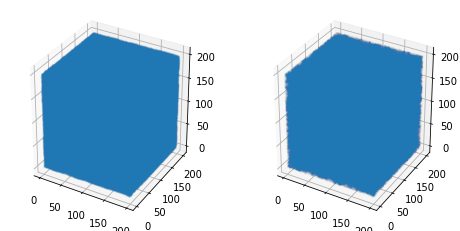

In [47]:
np.random.seed(12)

resolution = 200
linear_field = apply_powerlaw_power_spectrum3d(whitenoise3d(resolution))

t0 = 0.01
t1 = 0.05

x0, y0, z0 = evolved_particle_positions3d(linear_field, time=t0)
x1, y1, z1 = evolved_particle_positions3d(linear_field, time=t1)

print(linear_field.shape)


fig = plt.figure(figsize=plt.figaspect(0.5))

#ax = fig.add_subplot(1,2,1, projection='3d')
#ax.scatter(linear_field[1], linear_field[2], linear_field[3], s=0.001)

ax.scatter(x0, y0, z0, s=0.001, label = 'Time' + str(t0))
ax.legend()
ax = fig.add_subplot(1,2,1, projection='3d')

ax.scatter(x0, y0, z0, s=0.001, label = 'Time =' + str(t0))

ax2 = fig.add_subplot(1,2,2, projection='3d')

ax2.scatter(x1, y1, z1, s=0.0001, label = 'Time =' + str(t0))

plt.show()

/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  import sys
/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


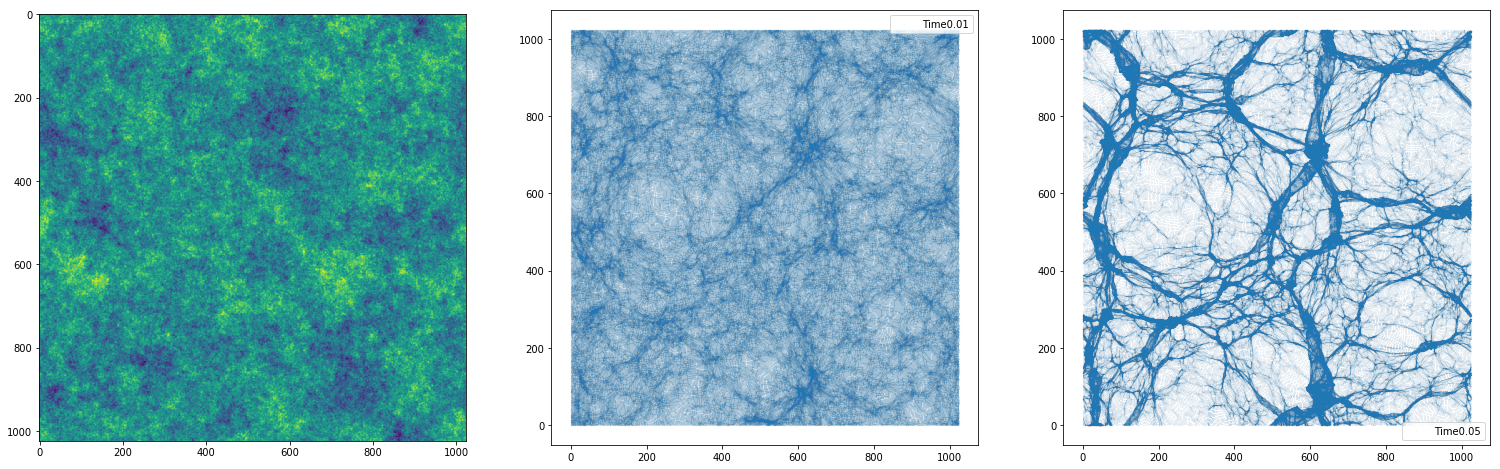

In [9]:
np.random.seed(11)

resolution = 1024
linear_field = apply_powerlaw_power_spectrum(whitenoise(resolution))

t0 = 0.01
t1 = 0.05
x0, y0 = evolved_particle_positions(linear_field, time=t0)
x1, y1 = evolved_particle_positions(linear_field, time=t1)

f, ax = plt.subplots(1, 3, figsize=(26,8))
ax[0].imshow(linear_field, label = 'Initial field')

ax[1].scatter(x0, y0, s=0.001, label = 'Time' + str(t0))
ax[2].scatter(x1, y1, s=0.001, label = 'Time' + str(t1))

ax[1].legend()
ax[2].legend()

plt.show()

# Generating 2D Outputs for Tensorflow

/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  import sys
/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1124930d0> (for post_execute):


KeyboardInterrupt: 

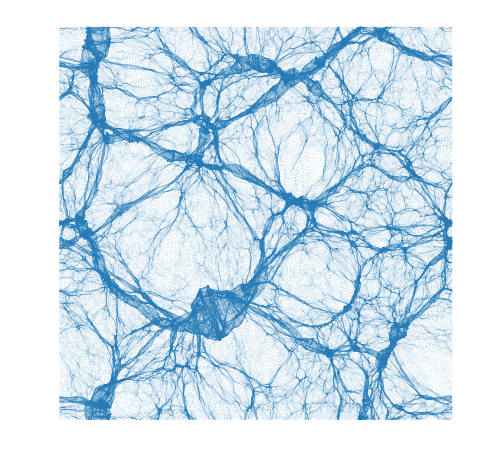

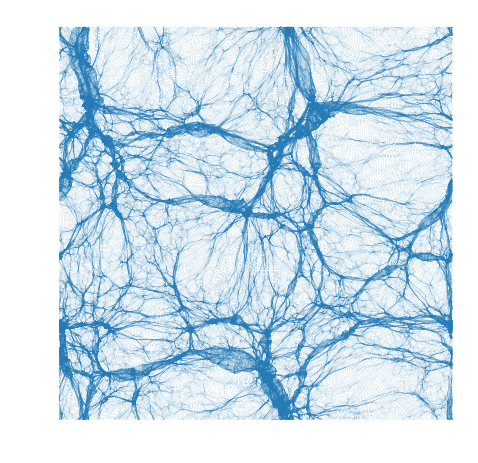

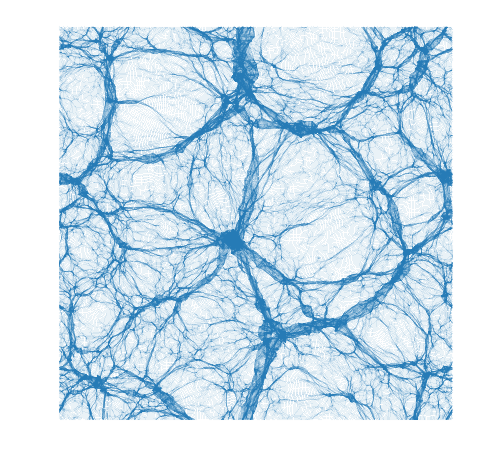

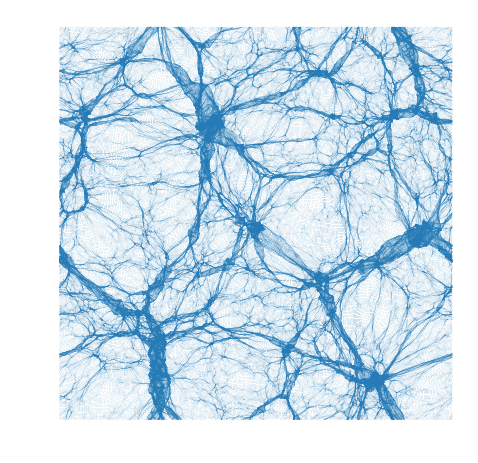

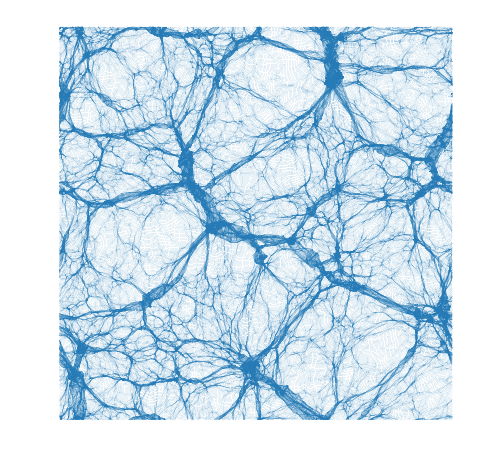

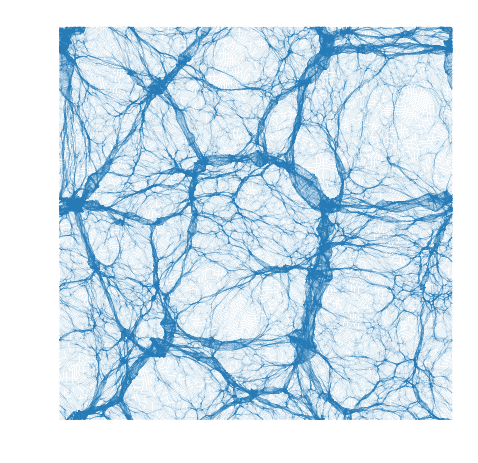

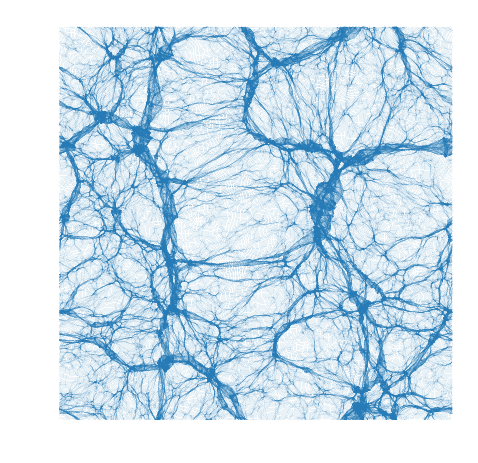

Error in callback <function flush_figures at 0x1124a2ae8> (for post_execute):


KeyboardInterrupt: 

In [25]:
#np.random.seed(11)

#linear_field = apply_powerlaw_power_spectrum(whitenoise(resolution))






resolution = 1024

t0 = 0.02
t1 = 0.05

for i in range(1000):
    np.random.seed(i)
    linear_field = apply_powerlaw_power_spectrum(whitenoise(resolution))
    x0, y0 = evolved_particle_positions(linear_field, time=t0)
    x1, y1 = evolved_particle_positions(linear_field, time=t1)

#    f, ax = plt.subplots(1, 3, figsize=(26,8))
 #  ax[0].imshow(linear_field, label = 'Initial field')

 #   ax[1].scatter(x0, y0, s=0.001, label = 'Time' + str(t0))
 #   ax[2].scatter(x1, y1, s=0.001, label = 'Time' + str(t1))

 #   ax[1].legend(x0, y0, s=0.001, label = 'Time' + str(t0))
 #   ax[2].legend()
 #   plt.figure(frameon=False)
    
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(6,6)
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.scatter(x1, y1, s=0.001, label = 'Time' + str(t1))
    #plt.show()
    fig.savefig(f'number={i}.png')

In [26]:
print(x1.shape)

(1048576,)


In [28]:
np.sqrt(1048576)

1024.0

In [30]:
# make_FTRecords.py

import os 
import tensorflow as tf 
from PIL import Image  #注意Image,后面会用到


In [52]:
cwd = os.getcwd()
#classes = {'cat','dog'} # 设置为两类
classes = {'t1'}

print(cwd)

img_path = cwd+"/number=1.png"
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")
#img_tensor = tf.image.decode_image(img_path)
img_tensor = tf.image.decode_image(img_raw,channels=3)

/Users/dongxiaofeng/Documents/GitHub/zeldo
<tf.Tensor: shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xb0\x00\...


In [53]:
print(img_tensor.shape)
print(img_tensor.dtype)

img_final = tf.image.resize(img_tensor, [432, 432])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(432, 432, 3)
<dtype: 'uint8'>
(432, 432, 3)
0.12156863
1.0


In [68]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [432, 432])
  image /= 255.0  # normalize to [0,1] range

  return image

In [56]:
def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [64]:
all_image_paths = []
for i in range(500):
    all_image_paths.append(cwd+'/number='+ str(i)+'.png')

In [63]:
print(all_image_paths[0])

/Users/dongxiaofeng/Documents/GitHub/zeldo/number=0.png


In [65]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [66]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [69]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

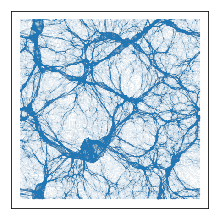

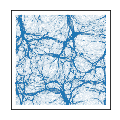

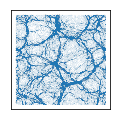

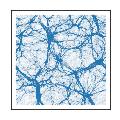

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
#  plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

ModuleNotFoundError: No module named 'keras'

# Train VAE

In [87]:
# Activate TF2 behavior:
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()


#import numpy as np
#import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.random.set_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt

mode = 'train'

ModuleNotFoundError: No module named 'keras'

In [88]:
num_epochs = 10 #5000
batch_size = 1
learning_rate = 1e-4
decay_rate = 0.0 # 1e-1

latent_dim = 2*2*2
epsilon_mean = 1.0
epsilon_std = 1e-2

In [ ]:
# Load data and shape for CNN
pca_vectors = np.load('PCA_Vectors.npy')
pca_coeffs = np.load('PCA_Coefficients.npy')
# Reconstruct fully
swe_data = np.transpose(np.matmul(pca_vectors,pca_coeffs))

preproc = Pipeline([('stdscaler', StandardScaler())])

swe_train = preproc.fit_transform(swe_data[:900,:])
swe_valid = preproc.transform(swe_data[900:,:])
swe_train = swe_train.reshape(900,64,64,1)
swe_valid = swe_valid.reshape(100,64,64,1)

# # Visualize transformations
# plt.figure()
# plt.imshow(swe_train[0].reshape(64,64))
# plt.show()

# plt.figure()
# plt.imshow(swe_train[1].reshape(64,64))
# plt.show()

# plt.figure()
# plt.imshow(swe_train[2].reshape(64,64))
# plt.show()
# exit()

# Shuffle
swe_train_data = np.copy(swe_train)
swe_valid_data = np.copy(swe_valid)

np.random.shuffle(swe_train_data)
np.random.shuffle(swe_valid_data)


def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )